In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
cohort_df = pd.read_csv('cvc_cohort.csv')
df = pd.read_csv('cvc_data_ned.csv.gz')
df = df.sort_values(['stay_id', 'hr']).reset_index(drop=True)
stays_in_cohort = cohort_df['stay_id'].unique()
df = df[df['stay_id'].isin(stays_in_cohort)]
print(df.shape)

(1950554, 23)


In [6]:
cohort_df = pd.read_csv('cvc_cohort.csv')
# exclusions
print(f"Initial cohort size: {cohort_df.shape[0]}")
cohort_df = cohort_df[cohort_df['age'] >= 18]
print(f"After age >= 18: {cohort_df.shape[0]}")
cohort_df = cohort_df[cohort_df['icu_los_day'] >= 0.5]
print(f"After ICU LOS >= 0.5 days: {cohort_df.shape[0]}")

# stays_with_cvc = df.loc[df['central_line'] == 1, 'stay_id'].unique()
# cohort_df = cohort_df[cohort_df['stay_id'].isin(stays_with_cvc)]
# print(f"After having CVC: {cohort_df.shape[0]}")

cohort_df.head()

has_central_line = df[df['central_line'] == 1]['stay_id'].unique()
has_vasopressors = df[df['ned'] > 0]['stay_id'].unique()
has_sepsis = df[df['sepsis3'] > 0]['stay_id'].unique()

# do a two-column table with the following
# count of subjects, % with central line, % with vasopressors
# median age, male/female, LOS
# % with any comorbidity
# % mortality 28 day
df_summary = pd.DataFrame({
    'count': [cohort_df.shape[0]],
    '% with central line': [len(has_central_line) / cohort_df.shape[0] * 100],
    '% with vasopressors': [len(has_vasopressors) / cohort_df.shape[0] * 100],
    'median age': [cohort_df['age'].median()],
    'male': [(cohort_df['gender'] == 'M').mean() * 100],
    'Sepsis-3 (%)': [len(has_sepsis) / cohort_df.shape[0] * 100],
})

# now filter cohort to with vasopressors
stays_with_neds = df.loc[df['ned'] > 0, 'stay_id'].unique()
cohort_df = cohort_df[cohort_df['stay_id'].isin(stays_with_neds)]
print(f"After having vasopressors: {cohort_df.shape[0]}")

# add these to summary
df_summary.loc[1] = [
    cohort_df.shape[0],
    len(cohort_df[cohort_df['stay_id'].isin(has_central_line)]) / cohort_df.shape[0] * 100,
    100.0,
    cohort_df['age'].median(),
    (cohort_df['gender'] == 'M').mean() * 100,
    len(cohort_df[cohort_df['stay_id'].isin(has_sepsis)]) / cohort_df.shape[0] * 100,
]

df_summary.T

Initial cohort size: 48653
After age >= 18: 48653
After ICU LOS >= 0.5 days: 44241
After having vasopressors: 16153


,0,1
count,44241.000000,16153.000000
% with central line,28.398996,75.868260
% with vasopressors,37.729708,100.000000
median age,65.000000,67.000000
male,58.570105,62.304216
Sepsis-3 (%),22.578604,60.515075


In [7]:
df = df.loc[df['stay_id'].isin(cohort_df['stay_id'].unique())]
df['has_vasopressor'] = (df['ned'] > 0).astype(int)

last_vaso_hr = df.loc[df['has_vasopressor'] == 1].groupby('stay_id')['hr'].max()
last_vaso_tuples = list(zip(last_vaso_hr.index, last_vaso_hr.values))
# optional dataframe
last_vaso_df = last_vaso_hr.rename('last_vasopressor_hr').reset_index()

df['last_vasopressor_hr'] = df['stay_id'].map(dict(last_vaso_tuples))

# do a delta - when central_line goes from 1 to 0, the cvc is removed
df['cvc_removed'] = df.groupby('stay_id')['central_line'].diff().fillna(0) == -1

In [8]:
# create survival dataframe:
# for each stay_id, find time of first central_line == 1 after last_vasopressor_hr
survival_data = []
for stay_id, group in df.groupby('stay_id'):
    last_vaso_hr = group['last_vasopressor_hr'].iloc[0]
    cvc_after_vaso = group[(group['hr'] >= last_vaso_hr) & (group['central_line'] == 1)]
    if cvc_after_vaso.empty:
        continue
    first_cvc_hr = cvc_after_vaso['hr'].min()
    cvc_removed = group[(group['hr'] >= first_cvc_hr) & (group['cvc_removed'] == True)]
    if not cvc_removed.empty:
        removal_hr = cvc_removed['hr'].min()
        duration = removal_hr - first_cvc_hr
        event_observed = 1
    else:
        duration = group['hr'].max() - first_cvc_hr
        event_observed = 0
    survival_data.append({
        'stay_id': stay_id,
        'duration': duration,
        'event_observed': event_observed
    })
survival_df = pd.DataFrame(survival_data)
survival_df.head()

,stay_id,duration,event_observed
0,30001148,19,0
1,30001446,3,1
2,30002415,23,1
3,30002548,21,0
4,30003749,2,1


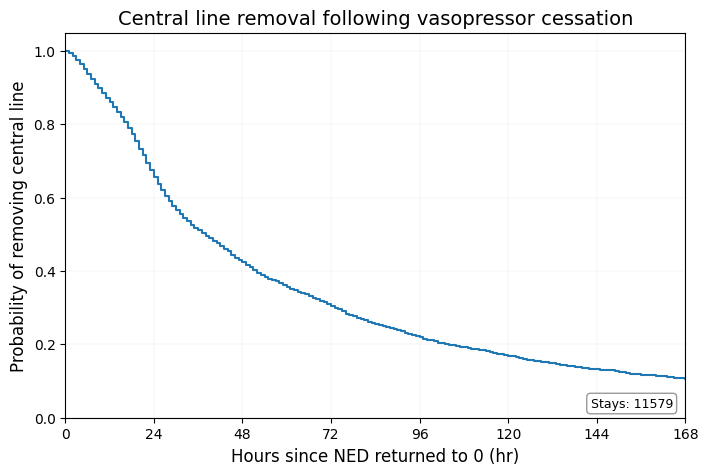

Survival cohorts constructed for 11579 stays.


In [9]:
# Manual Kaplan-Meier survival estimate
km_table = (survival_df.groupby('duration')
            .agg(events=('event_observed', 'sum'),
                 censored=('event_observed', lambda x: (x == 0).sum()))
            .reset_index()
            .sort_values('duration'))

timeline = [0.0]
survival_values = [1.0]
subjects_at_risk = len(survival_df)
current_survival = 1.0

for _, row in km_table.iterrows():
    if subjects_at_risk <= 0:
        break
    duration = row['duration']
    events = row['events']
    censored = row['censored']
    if events > 0:
        current_survival *= (1 - events / subjects_at_risk)
    timeline.append(duration)
    survival_values.append(current_survival)
    subjects_at_risk -= (events + censored)

fig, ax = plt.subplots(figsize=(8, 5))
ax.step(timeline, survival_values, where='post')
ax.set_xlabel('Hours since NED returned to 0 (hr)')
ax.set_ylabel('Probability of removing central line')
ax.set_title('Central line removal following vasopressor cessation')
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 24*7)  # Set x-axis limit to one week (168 hours)
# xticks every 24 hours
ax.set_xticks(range(0, 24*8, 24))
ax.grid(True, linewidth=0.3, alpha=0.3)

n_stays = survival_df.shape[0]
ax.annotate(f'Stays: {n_stays}', xy=(0.98, 0.02), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

# bigger fonts
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_size(14)

plt.show()

print(f'Survival cohorts constructed for {n_stays} stays.')

In [15]:
# create a stratified survival df
# for each stay_id, find time of first central_line == 1 after last_vasopressor_hr
mortality_df = cohort_df[['stay_id', 'icu_exp_flag']].copy()
icu_flag_map = mortality_df.set_index('stay_id')['icu_exp_flag']

survival_data = []
for stay_id, group in df.groupby('stay_id'):
    last_vaso_hr = group['last_vasopressor_hr'].iloc[0]

    if pd.isna(last_vaso_hr):
        continue

    max_hr = group['hr'].max()

    # require at least 12 hours after vasopressors
    if max_hr - last_vaso_hr < 12:
        continue

    cvc_after_vaso = group[(group['hr'] >= last_vaso_hr) & (group['central_line'] == 1)]
    if cvc_after_vaso.empty:
        continue

    first_cvc_hr = cvc_after_vaso['hr'].min()
    icu_flag = icu_flag_map.get(stay_id, pd.NA)
    if pd.isna(icu_flag):
        continue

    duration = max_hr - first_cvc_hr
    if duration < 0:
        continue

    event_observed = int(icu_flag == 1)
    survival_group = 'cvc_removed' if group['cvc_removed'].any() else 'cvc_kept'

    survival_data.append({
        'stay_id': stay_id,
        'first_cvc_hr': first_cvc_hr,
        'last_hr': max_hr,
        'duration': duration,
        'event_observed': event_observed,
        'icu_exp_flag': int(icu_flag),
        'survival_group': survival_group,
    })

survival_df = pd.DataFrame(survival_data)

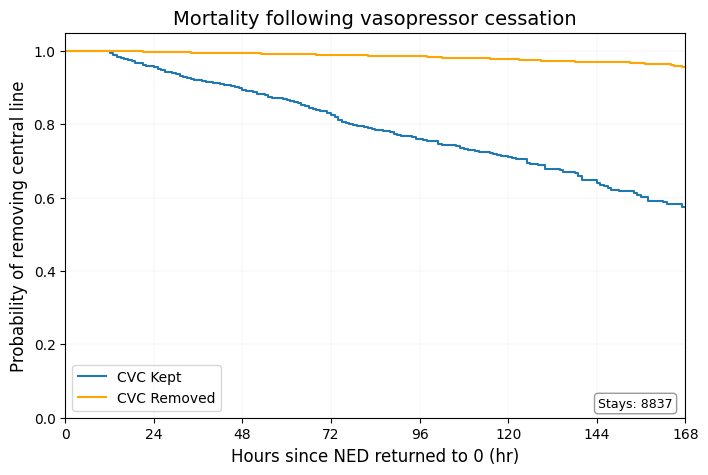

Survival cohorts constructed for 8837 stays.


In [12]:
# Manual Kaplan-Meier survival estimate
idx = survival_df['survival_group'] == 'cvc_kept'

def get_timeline_data(df, group):
    idx = df['survival_group'] == group
    km_table = (survival_df.loc[idx].groupby('duration')
                .agg(events=('event_observed', 'sum'),
                    censored=('event_observed', lambda x: (x == 0).sum()))
                .reset_index()
                .sort_values('duration'))

    timeline = [0.0]
    survival_values = [1.0]
    subjects_at_risk = len(survival_df.loc[idx])
    current_survival = 1.0

    for _, row in km_table.iterrows():
        if subjects_at_risk <= 0:
            break
        duration = row['duration']
        events = row['events']
        censored = row['censored']
        if events > 0:
            current_survival *= (1 - events / subjects_at_risk)
        timeline.append(duration)
        survival_values.append(current_survival)
        subjects_at_risk -= (events + censored)
    return timeline, survival_values

timeline, survival_values = get_timeline_data(survival_df, 'cvc_kept')

fig, ax = plt.subplots(figsize=(8, 5))
ax.step(timeline, survival_values, where='post')
ax.set_xlabel('Hours since NED returned to 0 (hr)')
ax.set_ylabel('Probability of removing central line')
ax.set_title('Mortality following vasopressor cessation')
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 24*7)  # Set x-axis limit to one week (168 hours)
# xticks every 24 hours
ax.set_xticks(range(0, 24*8, 24))
ax.grid(True, linewidth=0.3, alpha=0.3)

n_stays = survival_df.shape[0]
ax.annotate(f'Stays: {n_stays}', xy=(0.98, 0.02), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

# bigger fonts
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.title.set_size(14)

# repeat for the other group
timeline, survival_values = get_timeline_data(survival_df, 'cvc_removed')
ax.step(timeline, survival_values, where='post', color='orange')

# legend
ax.legend(['CVC Kept', 'CVC Removed'])

plt.show()

print(f'Survival cohorts constructed for {n_stays} stays.')

In [14]:
# Compute crude mortality for central line removal after last NED

# Eligible stays: >=2h of data in post_ned_zero_df after cessation
eligible_stays = df.loc[df['hr'] >= (df['last_vasopressor_hr'] + 2), 'stay_id'].unique()

# Identify mortality column in cohort_df
cohort_df['mortality_28d'] = (cohort_df['mort_day'] <= 28).astype(int)
candidate_mort_cols = [
    'mortality_28d', 'mortality_28_day', 'mortality_28days',
    'death_28d', 'death_28_day', 'died_28d', 'dead_28d',
    'hospital_expire_flag', 'mort_28d'
]
mort_col = next((c for c in candidate_mort_cols if c in cohort_df.columns), None)
if mort_col is None:
    raise ValueError(f"No mortality column found in cohort_df. Available columns: {list(cohort_df.columns)}")

# Only consider removal events and eligible stays
removals = survival_df[(survival_df['event_observed'] == 1) &
                       (survival_df['stay_id'].isin(eligible_stays))].copy()
removals['removal_groups'] = pd.cut(removals['duration'],
    bins=[-1, 12, 24, 48, float('inf')],
)

# Merge mortality indicator
removals = removals.merge(cohort_df[['stay_id', mort_col]], on='stay_id', how='left')

# Ensure mortality is binary int (0/1)
mort = removals[mort_col]
if mort.dtype == bool:
    removals[mort_col] = mort.astype(int)
elif mort.dtype.kind in ('i', 'u', 'f'):
    removals[mort_col] = mort.fillna(0).round().clip(0, 1).astype(int)
else:
    removals[mort_col] = mort.fillna(0).astype(int)

# Aggregate crude mortality rates
summary = (removals
           .groupby('removal_groups')
           .agg(n_stays=('stay_id', 'size'),
                deaths=(mort_col, 'sum'))
           .reset_index())
summary['crude_mortality_%'] = (summary['deaths'] / summary['n_stays'] * 100).round(2)
display(summary)

/var/folders/fn/qznlq4rd1sn88j6llg9sqk1m0000gn/T/ipykernel_89174/2887742457.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('removal_groups')


,removal_groups,n_stays,deaths,crude_mortality_%
0,"(-1.0, 12.0]",15,14,93.33
1,"(12.0, 24.0]",100,98,98.00
2,"(24.0, 48.0]",101,101,100.00
3,"(48.0, inf]",257,250,97.28
